In [ ]:
!mkdir -p /root/.kaggle/
import json
kaggledata = {"username":"aswinsda24c004","key":"ddff2d4804059a37008296281ee668dc"}
kagglejson = json.dumps(kaggledata)
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(kagglejson)
    
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c da5401-2024-ml-challenge
!unzip  da5401-2024-ml-challenge.zip
!rm da5401-2024-ml-challenge.zip

100%|█████████████████████████████████████▊| 1.05G/1.06G [00:48<00:00, 30.2MB/s]
100%|██████████████████████████████████████| 1.06G/1.06G [00:48<00:00, 23.7MB/s]
Archive:  da5401-2024-ml-challenge.zip
  inflating: embeddings_1.npy        
  inflating: embeddings_2.npy        
  inflating: icd_codes_1.txt         
  inflating: icd_codes_2.txt         
  inflating: sample_solution.csv     
  inflating: test_data.npy           


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import HyperModel, RandomSearch, Objective
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [5]:
embeddings1 = np.load('embeddings_1.npy')
embeddings2 = np.load('embeddings_2.npy')

with open('icd_codes_1.txt') as f:
    labels1 = f.read().strip().splitlines()

with open('icd_codes_2.txt') as f:
    labels2 = f.read().strip().splitlines()
    
X = np.concatenate((embeddings1, embeddings2), axis=0)
y = labels1 + labels2

In [6]:
# Multi hot encoding (OHE)
unique_labels = sorted(set(label for entry in y for label in entry.split(';')))
label_lookup = pd.Series(unique_labels)

y_encoded = np.zeros((len(y), len(unique_labels)), dtype=int)
for i, entry in enumerate(y):
    for label in entry.split(';'):
        if label in label_lookup.values:
            y_encoded[i, label_lookup[label_lookup == label].index[0]] = 1

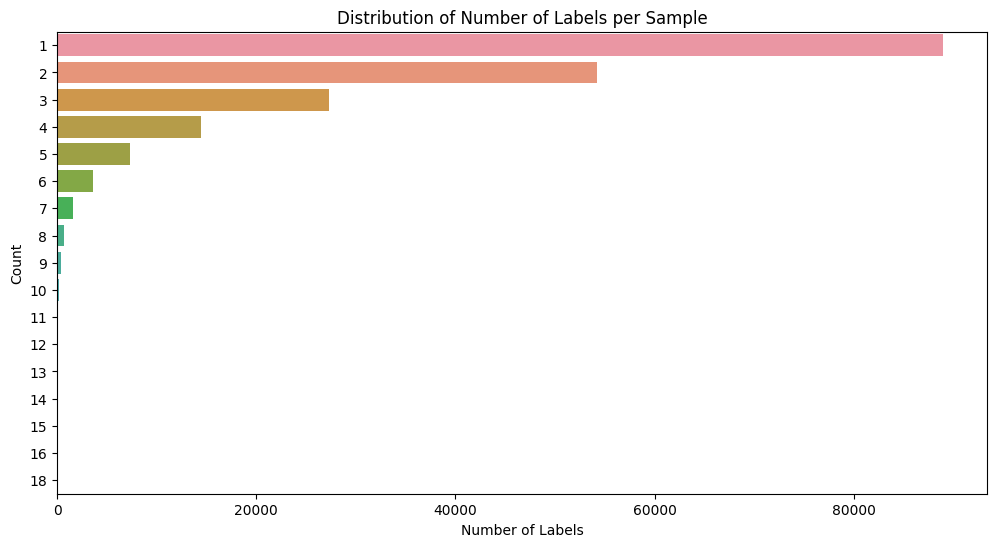

In [7]:
plt.figure(figsize=(12, 6))
sns.countplot(y=np.sum(y_encoded, axis=1))
plt.title('Distribution of Number of Labels per Sample')
plt.xlabel('Number of Labels')
plt.ylabel('Count')
plt.show()

In [ ]:
# Data Pre-processing 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)


In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)

In [10]:
f2_macro = lambda y_true, y_pred: fbeta_score(y_true, y_pred, beta=2, average='macro')

In [11]:
def avg_f2_macro(y_true, y_pred):
    y_pred = K.round(y_pred)
    y_true = K.cast(y_true, K.floatx())
    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1 - y_true) * y_pred, axis=0)
    fn = K.sum(y_true * (1 - y_pred), axis=0)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f2 = (5 * precision * recall) / (4 * precision + recall + K.epsilon())
    return K.mean(f2)

In [ ]:
def create_model(input_shape, output_units):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    model.add(layers.Dense(1024, activation='selu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1024, activation='selu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(output_units, activation='sigmoid'))  # Sigmoid for multi-label
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', avg_f2_macro])
    return model

mlp_model = create_model(X_train.shape[1], len(unique_labels))

In [18]:
class CustomLRScheduler(Callback):
    def __init__(self, patience=3, factor=0.5, min_lr=1e-6):#changed
        super(CustomLRScheduler, self).__init__()
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.best_accuracy = 0
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('accuracy') 

        if current_accuracy is None:
            return


        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.wait = 0
        else:
            self.wait += 1

            if self.wait >= self.patience:
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
                new_lr = max(old_lr * self.factor, self.min_lr)
                tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)
                print(f"\nEpoch {epoch + 1}: reducing learning rate from {old_lr:.6f} to {new_lr:.6f}")
                self.wait = 0 


In [ ]:

lr_scheduler = CustomLRScheduler(patience=5, factor=0.5, min_lr=1e-6)
checkpoint_callback = callbacks.ModelCheckpoint(
    'best_mlp_model.keras',  
    monitor='avg_f2_macro', 
    save_best_only=True,
    mode='max',
    verbose=1
)

history = mlp_model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=2048, 
    validation_data=(X_val, y_val), 
    callbacks=[checkpoint_callback],
    verbose=1
)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5878 - avg_f2_macro: 0.3682 - loss: 0.0014
Epoch 1: avg_f2_macro improved from -inf to 0.36635, saving model to best_mlp_model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.5878 - avg_f2_macro: 0.3682 - loss: 0.0014 - val_accuracy: 0.5840 - val_avg_f2_macro: 0.3743 - val_loss: 0.0015
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5897 - avg_f2_macro: 0.3673 - loss: 0.0014
Epoch 2: avg_f2_macro did not improve from 0.36635
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.5897 - avg_f2_macro: 0.3673 - loss: 0.0014 - val_accuracy: 0.5848 - val_avg_f2_macro: 0.3733 - val_loss: 0.0015
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5889 - avg_f2_macro: 0.3701 - loss: 0.0014
Epoch 3: avg_f2_macro improved from 0.36635 to 0.36841, saving model to best_mlp_model.keras
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.5889 - avg_f2_macro: 0.3701 - loss: 0.0014 -

In [26]:
best_mlp_model = models.load_model('best_mlp_model.keras', custom_objects={'avg_f2_macro': avg_f2_macro})


y_pred_best_mlp = best_mlp_model.predict(X_val, batch_size=2048)
accuracy_best_mlp = accuracy_score(y_val, np.round(y_pred_best_mlp))
f2_best_mlp = fbeta_score(y_val, np.round(y_pred_best_mlp), beta=2, average='macro')
print(f'Best MLP Model Accuracy: {accuracy_best_mlp:.4f}, F2 Score: {f2_best_mlp:.4f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Best MLP Model Accuracy: 0.6086, F2 Score: 0.5949


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [27]:
test_data = np.load('test_data.npy')

test_data_scaled = scaler.transform(test_data)

test_data_pca = pca.transform(test_data_scaled)

y_test_pred = best_mlp_model.predict(test_data_pca, batch_size=256)
y_test_pred_rounded = np.round(y_test_pred)

submission = pd.DataFrame({
    'id': range(1, len(y_test_pred) + 1), 
    'labels': [';'.join(sorted(label_lookup[y_test_pred_rounded[i] == 1])) for i in range(len(y_test_pred_rounded))]
})

submission.to_csv('submissions5.csv', index=False)

389/389 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
